<a href="https://colab.research.google.com/github/shani1610/learning-diffusion-models/blob/main/huggingface_course/02_diffusion_models_from_scratch(pokemons).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models from Scratch

Sometimes it is helpful to consider the simplest possible version of something to better understand how it works. We're going to try that in this notebook, beginning with a 'toy' diffusion model to see how the different pieces work, and then examining how they differ from a more complex implementation.

We will look at
- The corruption process (adding noise to data)
- What a UNet is, and how to implement an extremely minimal one from scratch
- Diffusion model training
- Sampling theory

Then we'll compare our versions with the diffusers DDPM implementation, exploring improvements over our mini UNet

It is also worth noting that most of the code here is for illustrative purposes, and I wouldn't recommend directly adopting any of it for your own work (unless you're just trying improve on the examples shown here for learning purposes).

## Setup and Imports:

In [1]:
%pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


## The Data

I give it a try with pokemon image dataset from kaggle

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path/"pokemons"

In [ ]:
# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pokemons.zip", "wb") as f:
        request = requests.get("https://github.com/shani1610/learning-diffusion-models/blob/main/data/pokemons.zip")
        print("Downloading pokemon data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pokemons.zip", "r") as zip_ref:
        print("Unzipping pokemons data...")
        zip_ref.extractall(image_path)

Visualize an image

Random image path: pokemons/train/pokemon/alakazam.png
Image class: pokemon
Image height: 120
Image width: 120


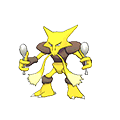

In [6]:
import random
from PIL import Image

# Set seed
random.seed(50) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Transforming data

Before we can use our image data with PyTorch we need to:

Turn it into tensors (numerical representations of our images).

Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [7]:
from torchvision import datasets, transforms

let's write a series of transform steps that:

Resize the images using transforms.Resize() (from about 120x120 to 28x28)

Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor()

In [8]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(28, 28)),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('pokemons/train'), PosixPath('pokemons/test'))

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## The Corruption Process

Pretend you haven't read any diffusion model papers, but you know the process involves adding noise. How would you do it?

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the `amount` of noise to add, and then we do:

`noise = torch.rand_like(x)`

`noisy_x =  (1-amount)*x + amount*noise`

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).

We can implement this fairly easily (just watch the shapes so you don't get burnt by broadcasting rules):

In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

And looking at the results visually to see that it works as expected:

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

As noise amount approaches one, our data begins to look like pure random noise. But for most noise amounts, you can guess the digit fairly well. Do you think this is optimal?

## The Model

We'd like a model that takes in a 28px noisy images and outputs a prediction of the same shape. A popular choice here is an architecture called a UNet. [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597), a UNet consists of a 'constricting path' through which data is compressed down and an 'expanding path' through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.

Some UNets feature complex blocks at each stage, but for this toy demo we'll build a minimal example that takes in a one-channel image and passes it through three convolutional layers on the down path (the down_layers in the diagram and code) and three on the up path, with skip connections between the down and up layers. We'll use max pooling for downsampling and `nn.Upsample` for upsampling rather than relying on learnable layers like more complex UNets.


This is what that looks like in code:

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

We can verify that the output shape is the same as the input, as we expect:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

This network has just over 300,000 parameters:

In [ ]:
sum([p.numel() for p in net.parameters()])

You can explore changing the number of channels in each layer or swapping in different architectures if you want.

## Training the network

So what should the model do, exactly? Again, there are various takes on this but for this demo let's pick a simple framing: given a corrupted input noisy_x the model should output its best guess for what the original x looks like. We will compare this to the actual value via the mean squared error.

We can now have a go at training the network.
- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly.

Feel free to modify this and see if you can get it working better!

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it by different amounts and then seeing the models predictions:

In [ ]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

You can see that for the lower amounts the predictions are pretty good! But as the level gets very high there is less for the model to work with, and by the time we get to amount=1 it outputs a blurry mess close to the mean of the dataset to try and hedge its bets on what the output might look like...

## Sampling

If our predictions at high noise levels aren't very good, how do we generate images?

Well, what if we start from random noise, look at the model predictions but then only move a small amount towards that prediction - say, 20% of the way there. Now we have a very noisy image in which there is perhaps a hint of structure, which we can feed into the model to get a new prediction. The hope is that this new prediction is slightly better than the first one (since our starting point is slightly less noisy) and so we can take another small step with this new, better prediction.

Repeat a few times and (if all goes well) we get an image out! Here is that process illustrated over just 5 steps, visualizing the model input (left) and the predicted denoised images (right) at each stage. Note that even though the model predicts the denoised image even at step 1, we only move x part of the way there. Over a few steps the structures appear and are refined, until we get our final outputs.

In [ ]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

We can split the process up into more steps, and hope for better images that way:

In [ ]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Not great, but there are some recognizable digits there! You can experiment with training for longer (say, 10 or 20 epochs) and tweaking model config, learning rate, optimizer and so on. Also, don't forget that fashionMNIST is a one-line replacement if you want a slightly harder dataset to try.

## Comparison To DDPM

In this section we'll take a look at how our toy implementation differs from the approach used in the other notebook ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)), which is based on the DDPM paper.

We'll see that


*   The diffusers `UNet2DModel` is a bit more advanced than our BasicUNet
*   The corruption process in handled differently
*   The training objective is different, involving predicting the noise rather than the denoised image
*   The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.
*   There are a number of different sampling strategies available, which should work better than our simplistic version above.

There have been a number of improvements suggested since the DDPM paper came out, but this example is hopefully instructive as to the different available design decisions. Once you've read through this, you may enjoy diving into the paper ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364) which explores all of these components in some detail and makes new recommendations for how to get the best performance.

If all of this is too technical or intimidating, don't worry! Feel free to skip the rest of this notebook or save it for a rainy day.




### The UNet

The diffusers UNet2DModel model has a number of improvements over our basic UNet above:

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep.
*   Downsampling and upsampling blocks with learnable parameters

Let's create and inspect a UNet2DModel:



In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
#print(model)

As you can see, a little more going on! It also has significantly more parameters than our BasicUNet:

In [ ]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

We can replicate the training shown above using this model in place of our original one. We need to pass both x and timestep to the model (here I always pass t=0 to show that it works without this timestep conditioning and to keep the sampling code easy, but you can also try feeding in `(amount*1000)` to get a timestep equivalent from the corruption amount). Lines changed are shown with `#<<<` if you want to inspect the code.

In [ ]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');